# Data Cookbook

**The four most useful data science techniques**
1. Cluster Analysis
2. API and web scrapping

In [29]:
# Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.vq import vq, kmeans
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

import requests
from bs4 import BeautifulSoup
import json

In [3]:
# Uploading the datasets
df_parks = pd.read_csv('parks_data_2024.csv')

# Cluster Analysis
Which one to use?

- hierarical: 

    - Exploring data relationships: Hierarchical clustering is ideal for uncovering hierarchical structures within your data, showing how clusters relate to each other at different levels of granularity.

    - Smaller datasets: It can be computationally expensive, making it less suitable for very large datasets.

    - Unknown number of clusters: It allows you to explore different levels of clustering without needing to predefine the number of clusters.

    - Exploring relationships between data points: It's useful when the relationships between data points are as important as the groupings themselves

- kmeans: 

    - Large datasets: K-means is efficient and scalable, making it suitable for large datasets where speed is a priority.

    - Known number of clusters: You need to know (or estimate) how many clusters you want to create.
    - Well-defined cluster structures: K-means performs best when clusters have a clear, spherical shape.
    - When speed and efficiency are important: K-means is faster and more computationally efficient than hierarchical clustering

**K-means clustering**

In [8]:
# Choose two columns to cluster
df_parks_col = df_parks[['Hoops','Pickleball_combined']].copy()
df_parks_col['Hoops'] = df_parks_col['Hoops'] * 2

# Normalize both of them
df_parks_col['Hoops_scaled'] = df_parks_col['Hoops'] / df_parks_col['Hoops'].std()
df_parks_col['Pickleball_combined_scaled'] = df_parks_col['Pickleball_combined'] / df_parks_col['Pickleball_combined'].std()
df_parks_col


,Hoops,Pickleball_combined,Hoops_scaled,Pickleball_combined_scaled
0,10.120269,2.891505,1.333337,2.638993
1,3.009799,1.447019,0.396539,1.320652
2,3.951966,0.693327,0.520668,0.632780
3,15.661273,1.410018,2.063360,1.286883
4,34.188730,1.628035,4.504337,1.485860
...,...,...,...,...
95,5.856951,0.864140,0.771649,0.788676
96,14.207006,2.468901,1.871762,2.253294
97,13.936624,1.030223,1.836139,0.940254
98,6.439824,1.623045,0.848442,1.481306


*First step is to figure out out the num of clusters*

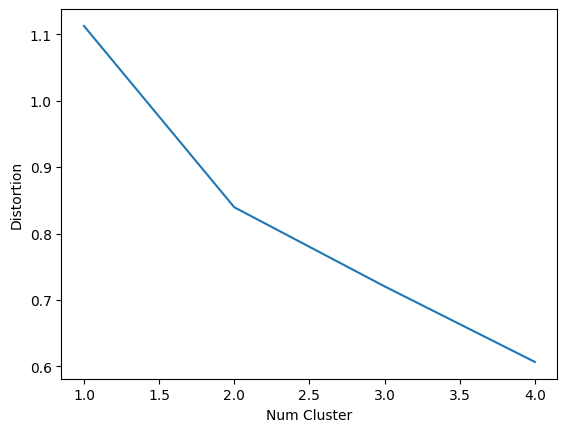

In [17]:
# Using the elbow plot method to find the number of clusters
distortions = []

# Loop through 5 clusters options
for i in range(1,5):
    cluster_center, distortion = kmeans(df_parks_col[['Hoops_scaled','Pickleball_combined_scaled']], i)
    distortions.append(distortion)

# Add the list of distortion and the range of number of clusters into a dataframe to plot 
elbow_plot_df = pd.DataFrame({'Num Cluster': range(1,5), 'Distortion': distortions})

# Plot the elbow to figure the number of clusters
sns.lineplot(x = 'Num Cluster', y = 'Distortion', data = elbow_plot_df)
plt.show()

*The most optimal number of clusters is 2*

**Create the clusters with two clusters**

In [18]:
cluster_centers, distortion = kmeans(df_parks_col[['Hoops_scaled','Pickleball_combined_scaled']], 2)

# Label the clusters on the dataframe
df_parks_col['label'], distortion = vq(df_parks_col[['Hoops_scaled','Pickleball_combined_scaled']], cluster_centers)

**Finally graph the two features with the cluster labeling**

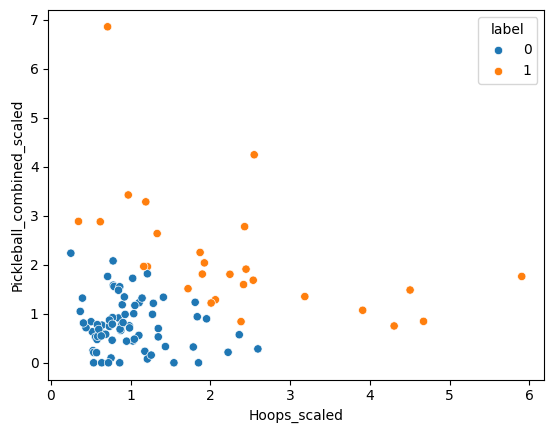

In [ ]:
sns.scatterplot(x = 'Hoops_scaled', y = 'Pickleball_combined_scaled', data = df_parks_col, hue = 'label')

plt.show()

**Hierarchical Clustering**

In [22]:
# Prepare the normalize the data

df_parks_col2 = df_parks[['investment_dollars', 'Rec_senior_centers']].copy()
df_parks_col2['investment_dollars_per_20k'] = df_parks_col2['investment_dollars'] * 20000

df_parks_col2['investment_dollars_per_20k_scaled'] = df_parks_col2['investment_dollars_per_20k'] / df_parks_col2['investment_dollars_per_20k'].std()
df_parks_col2['Rec_senior_centers_scaled'] = df_parks_col2['Rec_senior_centers'] / df_parks_col2['Rec_senior_centers'].std()

df_parks_col2

,investment_dollars,Rec_senior_centers,investment_dollars_per_20k,investment_dollars_per_20k_scaled,Rec_senior_centers_scaled
0,220.434307,1.120458,4.408686e+06,1.742835,2.013198
1,76.151009,0.289404,1.523020e+06,0.602078,0.519990
2,68.927449,0.207998,1.378549e+06,0.544966,0.373724
3,112.913565,0.654651,2.258271e+06,0.892736,1.176253
4,260.647703,1.221026,5.212954e+06,2.060777,2.193895
...,...,...,...,...,...
95,75.332502,0.384062,1.506650e+06,0.595606,0.690069
96,107.815311,0.303198,2.156306e+06,0.852427,0.544776
97,485.292066,2.003211,9.705841e+06,3.836897,3.599295
98,82.474460,0.471207,1.649489e+06,0.652073,0.846647


**Create a dendogram to figure the number of clusters**

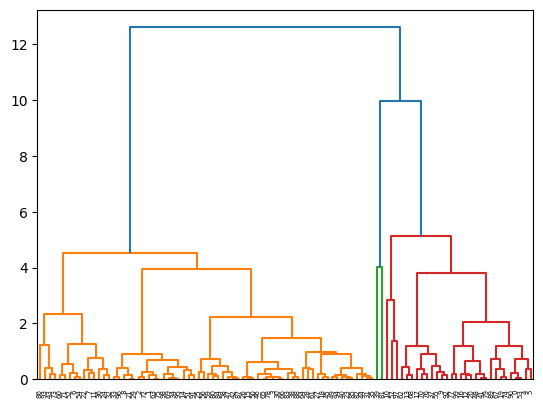

In [27]:
# First Figuring out the distance matrix using linkage
distance_matrix = linkage(df_parks_col2[['investment_dollars_per_20k_scaled','Rec_senior_centers_scaled']], method = 'ward', metric = 'euclidean')

d = dendrogram(distance_matrix)
plt.show()

*The nmost optimal number of clusters is 3*

**Now create the cluster labels based on the distance matrix**

In [28]:
df_parks_col2['label'] = fcluster(distance_matrix, 3, criterion='maxclust')

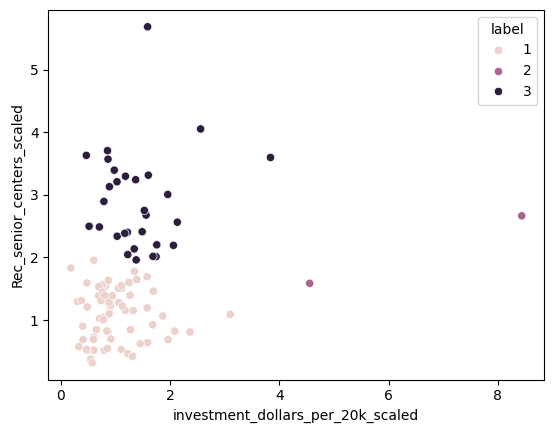

In [26]:
sns.scatterplot(x = 'investment_dollars_per_20k_scaled', y = 'Rec_senior_centers_scaled', data = df_parks_col2, hue = 'label')

plt.show()

# API and Web Scrapping

**API**

In [ ]:
# API key: hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj
# API website: https://api.nasa.gov/

api_key = 'hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj'
quary_start_date = '2025-03-25'
quary_end_date = '2025-04-01'

# Request access to the nasa url
url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={quary_start_date}&end_date={quary_end_date}&api_key={api_key}' # API url
response = requests.get(url) # request to get access the url

**Save API request to a dictionary**

In [ ]:
# Take request as json file and print it
json_data = response.json()
for keys in json_data.keys():
    print(keys + ':', json_data[keys])

links: {'next': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2025-04-01&end_date=2025-04-08&detailed=false&api_key=hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj', 'previous': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2025-03-18&end_date=2025-03-25&detailed=false&api_key=hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj', 'self': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2025-03-25&end_date=2025-04-01&detailed=false&api_key=hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj'}
element_count: 150
near_earth_objects: {'2025-03-30': [{'links': {'self': 'http://api.nasa.gov/neo/rest/v1/neo/3699902?api_key=hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj'}, 'id': '3699902', 'neo_reference_id': '3699902', 'name': '(2014 UV210)', 'nasa_jpl_url': 'https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=3699902', 'absolute_magnitude_h': 26.9, 'estimated_diameter': {'kilometers': {'estimated_diameter_min': 0.0110803882, 'estimated_diameter_max': 0.0247765013}, 'meters': {'estimated_diameter_min': 11.0803882126, 

**print the categories**

In [41]:
keys = json_data.keys()
print(keys)

dict_keys(['links', 'element_count', 'near_earth_objects'])


Now I can narrow my search towards each key and get information from there

In [42]:
for keys in json_data['near_earth_objects']:
    print(keys, ':', json_data['near_earth_objects'][keys])

2025-03-30 : [{'links': {'self': 'http://api.nasa.gov/neo/rest/v1/neo/3699902?api_key=hM54ehaUjXV1Ywpa45zhDevnniKTnzAwC67Y8Bvj'}, 'id': '3699902', 'neo_reference_id': '3699902', 'name': '(2014 UV210)', 'nasa_jpl_url': 'https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=3699902', 'absolute_magnitude_h': 26.9, 'estimated_diameter': {'kilometers': {'estimated_diameter_min': 0.0110803882, 'estimated_diameter_max': 0.0247765013}, 'meters': {'estimated_diameter_min': 11.0803882126, 'estimated_diameter_max': 24.7765012606}, 'miles': {'estimated_diameter_min': 0.0068850319, 'estimated_diameter_max': 0.0153953994}, 'feet': {'estimated_diameter_min': 36.3529808636, 'estimated_diameter_max': 81.2877363957}}, 'is_potentially_hazardous_asteroid': False, 'close_approach_data': [{'close_approach_date': '2025-03-30', 'close_approach_date_full': '2025-Mar-30 21:08', 'epoch_date_close_approach': 1743368880000, 'relative_velocity': {'kilometers_per_second': '3.2056986735', 'kilometers_per_hour': '115

**Now I can choose where to navigate and get whatever data I want from Nasa's website**

**Web Scrapping**

In [45]:
# URL to scrap
url = 'https://calendar.whitman.edu/'

# send a request to the link
response = requests.get(url)

# Using BeautifulSoap, parser teh html of the website
soup = BeautifulSoup(response.text, 'html.parser')

**find all the links in a website**

In [ ]:
# find all the tags that start with '<a'
html_links = soup.find_all('a')
html_links[:10]

[<a class="button" href="#main" id="jump-to-main">Jump the navigation</a>,
 <a aria-label="Link back to Whitman College home page." class="home-link" href="https://calendar.whitman.edu">
 <img alt="Whitman College Logo" src="https://www.whitman.edu/images/global/logos/wc-primary-white-rgb.svg"/>
 </a>,
 <a href="https://www.whitman.edu/admission-and-aid/applying-to-whitman">Apply</a>,
 <a href="https://www.whitman.edu/admission-and-aid/visit-whitman">Visit Whitman</a>,
 <a href="https://give.whitman.edu/">Make a Gift</a>,
 <a href="https://calendar.whitman.edu">Events</a>,
 <a href="/search/places" role="menuitem">Places</a>,
 <a href="/calendar" role="menuitem">Events</a>,
 <a href="/search/groups" role="menuitem">Groups</a>,
 <a href="/signup?school_id=91">
 <i class="fas fa-user fa-sm"><span class="sr-only">Sign Up</span></i>
 </a>]

*To get just the links themselves*

In [ ]:
for link in html_links[:10]:
    #.get() gets whats inside the <a ... >  
    print(link.get('href'))

#main
https://calendar.whitman.edu
https://www.whitman.edu/admission-and-aid/applying-to-whitman
https://www.whitman.edu/admission-and-aid/visit-whitman
https://give.whitman.edu/
https://calendar.whitman.edu
/search/places
/calendar
/search/groups
/signup?school_id=91


**Finding all the events names in Whitman's calendar**

In [91]:
# the whole div tag contains the events information with the date and name of events

# choose the inside of the tag that is "class =" and whatever it equals to
# this will get all teh div tags that have a class equal to em-card_text

events = soup.find_all('div', {'class':'em-card_text'})
events

[<div class="em-card_text">
 <h3 class="em-card_title">
 <a href="https://calendar.whitman.edu/event/2025-baccalaureate-ceremony">2025 Baccalaureate Ceremony</a>
 </h3>
 <p class="em-text_icon"><i class="fas fa-calendar"></i>
                   
                     Saturday, May 24, 2025 2:30 pm to 3:30 pm
                   
                 </p>
 <p class="em-text_icon">
 <a href="https://calendar.whitman.edu/cordiner_hall"><i class="fas fa-map-marker-alt"></i>Cordiner Hall</a>
 </p>
 <div class="em-card_share">
 <div class="em-share_dropdown tr-appear-checkbox">
 <button aria-controls="event-share-buttons-49465531311846" aria-haspopup="true" class="em-share-button em-link" data-action="dropdown-toggle" data-target=".em-list-buttons-event_instance_49465531311846" data-toggle-class="em-active">
 <i class="fas fa-share-alt"><span class="sr-only">Share 2025 Baccalaureate Ceremony</span></i>
 </button>
 <ul class="em-list-buttons-event_instance_49465531311846" id="event-share-buttons-49

In [ ]:
# to remove all the html things and get the text inside the <> ... <>

for event in events:
    # event is a single line of html inside the events list

    # .get_text() gets whats text insde the <> ... <>
    # while strip = True removes all the unecessary whitespace
    text = event.get_text(strip=True)

    # the titles happen to be a link in the body of the div tags of every event
    # the .find() works on single tag only not a list of them like events
    event_name = event.find('a').get_text()
    print(event_name)

2025 Baccalaureate Ceremony
139th Commencement Ceremony
Final Exams - 9-11am and 2-4pm
Martial Arts 5/18/25
Final Exams - 9-11am and 2-4pm
Applications for Incompletes due to Dean of Students by 4pm.
End of Semester
Last day to pre-register for Fall 2025
Grieving@Whitman
Senior grades due 9am
Staff Recognition Breakfast
Chess Club
2025 Baccalaureate Ceremony
139th Commencement Ceremony


# 